<a href="https://colab.research.google.com/github/NicholasMcFadden/NLP-Text_Mining/blob/main/Final_Project_Topic_Modeling_LDA_MALLET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyLDAvis
!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 14.9 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 36.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=26528012 sha256

In [ ]:
# Topic Modelling demo using LDA and LDA-MALLET k-clusters
# for clustering concepts that have similar semantic import to discover themes in text

# Importing libraries, methods, etc
import os
import re
import numpy as np
from numpy import *
import pandas as pd
from pprint import pprint

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

# Gensim libraries
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models import word2vec
from gensim.test.utils import common_texts
from gensim.sklearn_api import W2VTransformer

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# SpaCy
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing dataset
# available at the Kaggle competitions website (https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews?select=tripadvisor_hotel_reviews.csv)
# We will use 'pandas', a panel (tabular) data Python library for manipulating tables
# Using pandas to open csv file as a table: 
df = pd.read_csv("drive/Shareddrives/IST_736_Final_Project/tripadvisor_hotel_reviews.csv")

# Taking a look at the data in a table format:
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [ ]:
# Checking how many rows (or 'observations') this table has:
len(df)

20491

In [ ]:
# # Let's filter for 'positive' labels only:
# df_pos= df[df['airline_sentiment'].str.contains("positive")]

# # Visualizing the filtered results
# df_pos.head()


In [ ]:
# how long is the list of elements (rows) in our filtered table?
# i.e. how many tweets labeled 'positive' have been extracted?
# len(df_pos)

In [ ]:
# Extracting the 'Review' column from our filtered 'positive' sentiment tweets 
# Converting that content into a Python list:
data = df.Review.tolist()


In [ ]:
#Extracting the "Rating" column for later append to output model csv
ratings = df.Rating.tolist()

In [ ]:
print(data[:1])

['nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  ']


In [ ]:
# Preprocessing using Gensim's "simple_preprocess" library
# this library lowercases, tokenizes, and performs 
# all other basic preprocesing to turn text into data
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# create one list per review, with all clean tokens
data_words = list(sent_to_words(data))

# confirm the output for 1 review
print(data_words[:1])

# check the length of our list of lists. It should equal the number of rows with text
# in the dataframe:
print(len(data_words))

[['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'reviews', 'did', 'valet', 'parking', 'check', 'quick', 'easy', 'little', 'disappointed', 'non', 'existent', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'woke', 'stiff', 'neck', 'high', 'pillows', 'not', 'soundproof', 'like', 'heard', 'music', 'room', 'night', 'morning', 'loud', 'bangs', 'doors', 'opening', 'closing', 'hear', 'people', 'talking', 'hallway', 'maybe', 'just', 'noisy', 'neighbors', 'aveda', 'bath', 'products', 'nice', 'did', 'not', 'goldfish', 'stay', 'nice', 'touch', 'taken', 'advantage', 'staying', 'longer', 'location', 'great', 'walking', 'distance', 'shopping', 'overall', 'nice', 'experience', 'having', 'pay', 'parking', 'night']]
20491


In [ ]:
# Building the bigram and trigram models using Gensim 
# first pass the data through the Phrases method, then through Phraser
# Documentation here: https://radimrehurek.com/gensim/models/phrases.html

# create bigrams first. 
bigram = Phrases(data_words, min_count=5, threshold=50) 
# ... where min_count is the minimum frequency of bigrams (in this case, we discard bigrams 
# with less than 5 occurrences), and higher threshold represents fewer phrases.

# Trigrams (3-word concepts) after bigrams
# Gensim makes you pass bigrams through the Phrases method again to obtain trigrams
# this is because Gensim turns bigrams into unigrams by adding an undescore ("_") in between words
# for instance,"get together" turns into "get_together", which is now an unigram
# you see that this method turns bigram into unigrams
# so running the bigram method again adds a third word to that pair
trigram = Phrases(bigram[data_words], threshold=50) 

# Creating variables with bigrams and trigrams using Phraser
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


In [ ]:
# take a look at item #10 to see if there is a bigram there
print(bigram_mod[data_words[50]])
print(trigram_mod[data_words[50]])

['excellent', 'way', 'stayed', 'inn', 'market', 'memorial', 'day', 'weekend', 'room', 'large', 'great', 'view', 'water', 'sure', 'request', 'way', 'advance', 'hotel', 'quiet', 'fully_booked', 'crowded', 'service', 'impeccable', 'staff', 'well', 'mannered', 'friendly', 'ca', 'fault', 'anything', 'it', 'great', 'location', 'right', 'pike_place', 'market', 'near', 'lots', 'great', 'restaurants', 'like', 'etta', 'chez', 'shea']
['excellent', 'way', 'stayed', 'inn', 'market', 'memorial_day', 'weekend', 'room', 'large', 'great', 'view', 'water', 'sure', 'request', 'way', 'advance', 'hotel', 'quiet', 'fully_booked', 'crowded', 'service', 'impeccable', 'staff', 'well', 'mannered', 'friendly', 'ca', 'fault', 'anything', 'it', 'great', 'location', 'right', 'pike_place', 'market', 'near', 'lots', 'great', 'restaurants', 'like', 'etta', 'chez', 'shea']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# we will use the bigrams code above to create funtions that will process the entire corpus

# from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Function to create bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Function to create trigrams
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Function to lemmatize
# We use a library called 'spacy' (https://spacy.io/) for this
# To speeed up processing, we'll only lemmatize nouns, adjectives, verbs, and adverbs
# since these are the most important words for polarity (remember we are processing text
# deemed 'positive' in polarity)
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# process text
# remove stopwords and create a variable with the clean corpus
data_words_nostops = remove_stopwords(data_words)

# use cleaned corpus in 'data_words_nostops' to create: 
data_words_bigrams = make_bigrams(data_words_nostops)

# initialize spacy's 'en_core_web_sm' package for Website text (https://spacy.io/models/en)
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 2600000

# extract our groups of words and lemmatize them
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[['nice', 'hotel', 'expensive', 'parking', 'get', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrive', 'late', 'evening', 'take', 'advice', 'previous_reviews', 'valet_parking', 'check', 'quick', 'easy', 'little', 'disappointed', 'non_existent', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'wake', 'stiff', 'neck', 'high', 'pillow', 'soundproof', 'hear', 'music', 'room', 'night', 'morning', 'loud', 'bang', 'door', 'opening_close', 'hear', 'people', 'talk', 'hallway', 'maybe', 'noisy', 'neighbor', 'aveda_bath', 'product', 'nice', 'stay', 'nice', 'touch', 'take', 'advantage', 'stay', 'long', 'location', 'great', 'walking_distance', 'shop', 'overall', 'nice', 'experience', 'pay', 'parking', 'night'], ['nothing_special', 'charge', 'diamond_member', 'decide', 'chain', 'shoot', 'anniversary', 'seattle', 'start', 'book', 'suite', 'pay', 'extra', 'website', 'description', 'suite', 'bedroom', 'bathroom', 'standard', 'hotel', 'room', 'take', 'print', 'reservation', '

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency. "id2word" matches words with their IDs in the corpus
# "doc2bow" converts the corpus into a bag of words 
corpus = [id2word.doc2bow(text) for text in texts]

# View frequency tuples: first index is the word and second is the frequency for that word
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 5), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 3), (48, 1), (49, 1), (50, 1), (51, 3), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1)]]


In [ ]:
# Printing the first token
id2word[0]

'advantage'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advantage', 1),
  ('advice', 1),
  ('anniversary', 1),
  ('arrive', 1),
  ('aveda_bath', 1),
  ('bang', 1),
  ('bed', 1),
  ('check', 1),
  ('clean', 1),
  ('comfortable', 1),
  ('deal', 1),
  ('disappointed', 1),
  ('door', 1),
  ('easy', 1),
  ('evening', 1),
  ('expensive', 1),
  ('experience', 1),
  ('get', 1),
  ('good', 1),
  ('great', 1),
  ('hallway', 1),
  ('hear', 2),
  ('high', 1),
  ('hotel', 2),
  ('late', 1),
  ('little', 1),
  ('location', 1),
  ('long', 1),
  ('loud', 1),
  ('maybe', 1),
  ('morning', 1),
  ('music', 1),
  ('neck', 1),
  ('neighbor', 1),
  ('nice', 5),
  ('night', 2),
  ('noisy', 1),
  ('non_existent', 1),
  ('opening_close', 1),
  ('overall', 1),
  ('parking', 2),
  ('pay', 1),
  ('people', 1),
  ('pillow', 1),
  ('previous_reviews', 1),
  ('product', 1),
  ('quick', 1),
  ('room', 3),
  ('shop', 1),
  ('size', 1),
  ('soundproof', 1),
  ('stay', 3),
  ('stiff', 1),
  ('take', 2),
  ('talk', 1),
  ('touch', 1),
  ('valet_parking', 1),
  ('view', 1)

In [ ]:
# Build LDA model
# Avoiding future changes warning messages
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Parametize the model
# See details for parameters values: https://radimrehurek.com/gensim/models/ldamodel.html
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [ ]:
# Print keyword for the topics created 
# the number besides the topic shows the probability score for that topic within the cluster
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"beach" + 0.029*"resort" + 0.029*"food" + 0.029*"pool" + 0.019*"good" '
  '+ 0.018*"day" + 0.017*"time" + 0.015*"restaurant" + 0.014*"drink" + '
  '0.014*"great"'),
 (1,
  '0.065*"hotel" + 0.039*"room" + 0.034*"stay" + 0.024*"great" + 0.020*"good" '
  '+ 0.019*"staff" + 0.013*"location" + 0.013*"breakfast" + 0.012*"night" + '
  '0.011*"clean"'),
 (2,
  '0.029*"room" + 0.012*"really" + 0.012*"think" + 0.011*"get" + 0.010*"night" '
  '+ 0.010*"nice" + 0.010*"thing" + 0.009*"look" + 0.009*"place" + '
  '0.008*"bed"'),
 (3,
  '0.026*"check" + 0.026*"room" + 0.017*"tell" + 0.016*"day" + 0.015*"arrive" '
  '+ 0.015*"ask" + 0.013*"leave" + 0.013*"book" + 0.012*"desk" + 0.011*"hour"'),
 (4,
  '0.034*"sand" + 0.028*"royal" + 0.026*"wave" + 0.025*"ticket" + '
  '0.022*"dream" + 0.021*"section" + 0.019*"grill" + 0.018*"lead" + '
  '0.013*"waste" + 0.013*"harbour"')]


In [ ]:
doc_lda

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # More than one model is needed for this measure. 
#The model with the lowest perplexity is generally considered the “best”.
# Compute Coherence Score. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.
# A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.356780723191307

Coherence Score:  0.3413594491170643


In [ ]:
from __future__ import division

# Visualize the topics using pyLDAvis
# Save the visualization as an html file
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,  mds='mmds')
pyLDAvis.display(vis, template_type='notebook') 
vis

pyLDAvis.save_html(vis,'drive/Shareddrives/IST_736_Final_Project/Hotel_LDA_viz3.html')


In [ ]:
# Download Mallet into drive -- OBly run once
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
#/content/drive/Shareddrives/IST_736_Final_Project/Mallet-202108
## Creating LDA-Mallet model
# MALLET is an optimized type of LDA model
# Follow instructions to download MALLET from: http://mallet.cs.umass.edu/download.php
from gensim.models.wrappers import LdaMallet
# os.environ.update({r'MALLET_HOME':r'/content/drive/Shareddrives/IST_736_Final_Project/Mallet-202108'})
# mallet_path = r'/content/drive/Shareddrives/IST_736_Final_Project/Mallet-202108/bin/mallet'
'''Code from https://colab.research.google.com/github/polsci/colab-gensim-mallet/blob/master
/topic-modeling-with-colab-gensim-mallet.ipynb#scrollTo=9wK2PPaoMMLr'''

os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [ ]:
# Show MALLET clusters and their topics
# the number besides the topic shows the probability score for that topic within the cluster
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('great', 0.053995960494376195),
   ('stay', 0.05302499675727759),
   ('staff', 0.05064947097300202),
   ('place', 0.023406896807308168),
   ('service', 0.02226175255248578),
   ('friendly', 0.01593937035595827),
   ('wonderful', 0.014949876776548632),
   ('return', 0.01451998443493246),
   ('love', 0.013063538829284562),
   ('restaurant', 0.012340874979153928)]),
 (1,
  [('room', 0.12942161789338852),
   ('nice', 0.0350667905353096),
   ('bed', 0.024918007403966613),
   ('small', 0.024309221175907548),
   ('night', 0.0233168644342159),
   ('bathroom', 0.020536857959264108),
   ('stay', 0.020167363427783174),
   ('hotel', 0.01943189336035922),
   ('view', 0.018330447756992243),
   ('area', 0.01499795898258801)]),
 (2,
  [('food', 0.02493104637131529),
   ('resort', 0.02343884675056025),
   ('beach', 0.022867824513014997),
   ('good', 0.022813954490605068),
   ('pool', 0.02055680055162903),
   ('day', 0.017171069643164973),
   ('time', 0.015554968970867092),
   ('people', 0.0154

In [ ]:
#pyLDAviz bug fix from https://github.com/RaRe-Technologies/gensim/issues/2069 
from gensim.models.ldamodel import LdaModel

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,alpha=mallet_model.alpha, eta=0, iterations=1000,gamma_threshold=0.001,dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
# Convert the MALLET model to a Gensim compatible vector
model1 = ldaMalletConvertToldaGen(ldamallet)
# Visualize this new model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model1, corpus, id2word)
vis
pyLDAvis.save_html(vis, 'drive/Shareddrives/IST_736_Final_Project/hotel_MALLET_viz3.html')

In [ ]:
# Now we will take a step back
# We know that it is hard to know how many clusters we should choose ahead of time
# to avoid running the code several times with different cluster settings,
# we can create several models with different numbers of clusters
# and use evaluation measures to choose the best option
# "Coherence" is the most reliable evaluation measure for clusters
# It measures the consistentcy of semantic meaning within a cluster
# More about Coherence:
# https://mimno.infosci.cornell.edu/nips2013ws/nips2013tm_submission_7.pdf
# https://stackoverflow.com/questions/54762690/evaluation-of-topic-modeling-how-to-understand-a-coherence-value-c-v-of-0-4

# We'll build a function to compute those Coherence values
# (more about how this code works: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/)
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    start : number of topics in first model
    step : number of topics added in each iteration

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Using that function to compute coherence values in our corpus (this might take some time to run)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus,
                                                          texts=data_lemmatized, limit=40, start=2, step=2)

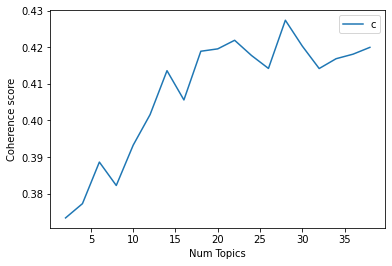

In [ ]:
# Creating a graph to show coherence results by clusters
# so we can choose the model with the number of clusters that has the highest evaluation score
# 0.7 is the best score to use
# (see: https://stackoverflow.com/questions/54762690/evaluation-of-topic-modeling-how-to-understand-a-coherence-value-c-v-of-0-4)
limit=40; start=2; step=2; #'steps' is x increase in number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Printing the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3734
Num Topics = 4  has Coherence Value of 0.3772
Num Topics = 6  has Coherence Value of 0.3886
Num Topics = 8  has Coherence Value of 0.3822
Num Topics = 10  has Coherence Value of 0.3932
Num Topics = 12  has Coherence Value of 0.4016
Num Topics = 14  has Coherence Value of 0.4136
Num Topics = 16  has Coherence Value of 0.4056
Num Topics = 18  has Coherence Value of 0.4189
Num Topics = 20  has Coherence Value of 0.4195
Num Topics = 22  has Coherence Value of 0.4219
Num Topics = 24  has Coherence Value of 0.4177
Num Topics = 26  has Coherence Value of 0.4142
Num Topics = 28  has Coherence Value of 0.4274
Num Topics = 30  has Coherence Value of 0.4203
Num Topics = 32  has Coherence Value of 0.4142
Num Topics = 34  has Coherence Value of 0.4169
Num Topics = 36  has Coherence Value of 0.4181
Num Topics = 38  has Coherence Value of 0.42


In [ ]:
# Selecting the most optimal model
# In this case, model #19 (index 18) has the more balanced score (not too high, not too low)
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.063*"nice" + 0.041*"stay" + 0.030*"hotel" + 0.026*"place" + 0.025*"great" '
  '+ 0.022*"free" + 0.021*"clean" + 0.020*"close" + 0.020*"location" + '
  '0.019*"street"'),
 (1,
  '0.048*"good" + 0.044*"price" + 0.043*"service" + 0.030*"pay" + '
  '0.028*"expect" + 0.022*"star" + 0.019*"rate" + 0.018*"quality" + '
  '0.016*"high" + 0.014*"average"'),
 (2,
  '0.135*"room" + 0.043*"night" + 0.028*"door" + 0.019*"noise" + 0.017*"hear" '
  '+ 0.017*"floor" + 0.016*"sleep" + 0.013*"window" + 0.012*"open" + '
  '0.012*"work"'),
 (3,
  '0.054*"time" + 0.046*"people" + 0.031*"thing" + 0.029*"bad" + 0.028*"day" + '
  '0.027*"place" + 0.018*"review" + 0.016*"good" + 0.015*"make" + '
  '0.013*"money"'),
 (4,
  '0.120*"staff" + 0.115*"great" + 0.075*"friendly" + 0.074*"stay" + '
  '0.067*"location" + 0.066*"helpful" + 0.061*"clean" + 0.053*"excellent" + '
  '0.027*"comfortable" + 0.024*"breakfast"'),
 (5,
  '0.040*"service" + 0.032*"staff" + 0.029*"time" + 0.025*"family" + '
  '0.024*"guest

In [ ]:
# Creating a new vector to visualize the most optimal model
model2 = ldaMalletConvertToldaGen(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model2, corpus, id2word)
vis
pyLDAvis.save_html(vis, 'drive/Shareddrives/IST_736_Final_Project/hotel_mallet_optimal_model_viz4-12.html')

In [ ]:
##Finding the dominant topic in each sentence
# "Dominant topic" is the most relevant (in terms of proability) topic in a cluser
# this is a way to obtain labels for clusters, by assigning that dominant subject to the cluster
#saving topics-documents mapping list on a csv file
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data, ratings=ratings):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
        # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        # Add Original ratings as column to end of output
    user_ratings = pd.Series(ratings)    
    sent_topics_df = pd.concat([sent_topics_df, user_ratings], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Formatting
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Rating']

# Saving in csv file
# this will give us a list of all tweets with the cluster they belong to
# which is a fast way to get an annotated corpus without human labeling@
pd.DataFrame(df_dominant_topic).to_csv('drive/Shareddrives/IST_736_Final_Project/mallet_optimal_model_ratings4-12.csv', index=False)

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Rating
0,0,2,0.1644,"room, night, door, noise, hear, floor, sleep, ...",nice hotel expensive parking got good deal sta...,4
1,1,9,0.2248,"check, room, arrive, desk, call, book, reserva...",ok nothing special charge diamond member hilto...,2
2,2,7,0.1722,"room, bed, bathroom, small, large, shower, nic...",nice rooms not 4* experience hotel monaco seat...,3
3,3,0,0.1150,"nice, stay, hotel, place, great, free, clean, ...","unique, great stay, wonderful time hotel monac...",5
4,4,3,0.1478,"time, people, thing, bad, day, place, review, ...","great stay great stay, went seahawk game aweso...",5
5,5,7,0.1306,"room, bed, bathroom, small, large, shower, nic...",love monaco staff husband stayed hotel crazy w...,5
6,6,10,0.0974,"room, view, stay, service, hotel, night, suite...","cozy stay rainy city, husband spent 7 nights m...",5
7,7,8,0.0976,"great, wonderful, love, staff, beautiful, perf...","excellent staff, housekeeping quality hotel ch...",4
8,8,7,0.1323,"room, bed, bathroom, small, large, shower, nic...","hotel stayed hotel monaco cruise, rooms genero...",5
9,9,4,0.0985,"staff, great, friendly, stay, location, helpfu...",excellent stayed hotel monaco past w/e delight...,5


In [ ]:
# # Making sure we still have the same number of tweets from our 'postivie' su-corpus
# len(df_dominant_topic)

In [ ]:
##Find the most representative document for each topic
# this is an inverse calculation for the one above
# instead of finding the most relevant topic, we look for the document
# that shows that topic more preemanently

# Grouping top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Rating"]

pd.DataFrame(sent_topics_sorteddf_mallet).to_csv('drive/Shareddrives/IST_736_Final_Project/sent_topics_sorteddf_mallet.csv', index=False)

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Rating
0,0,0.3222,"nice, stay, hotel, place, great, free, clean, ...",great little place stay booked night stay base...,5
1,1,0.2837,"good, price, service, pay, expect, star, rate,...","overrated, overrated, review las casistas prop...",1
2,2,0.3240,"room, night, door, noise, hear, floor, sleep, ...","disapointment, excited stay hotel visiting web...",2
3,3,0.3730,"time, people, thing, bad, day, place, review, ...","ca n't wait till year, 2nd 16th 2008we stayed ...",5
4,4,0.2283,"staff, great, friendly, stay, location, helpfu...",great hotel friendly staff great location stay...,5
5,5,0.3241,"service, staff, time, family, guest, restauran...",magnificent resort ages just returned week dre...,5
6,6,0.2565,"hotel, stay, room, night, book, location, week...",overbookings aware intention weekend recently ...,1
7,7,0.3779,"room, bed, bathroom, small, large, shower, nic...",fab midtown pick new london nyc fabulous midto...,4
8,8,0.2818,"great, wonderful, love, staff, beautiful, perf...","no need look further-hotel ungherese, husband ...",5
9,9,0.5112,"check, room, arrive, desk, call, book, reserva...","sure detailed confirmation rates, just returne...",3


In [ ]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

pd.DataFrame(df_dominant_topics).to_csv('drive/Shareddrives/IST_736_Final_Project/df_dominant_topics.csv', index=False)


# Show
df_dominant_topics[:20]

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,2,"room, night, door, noise, hear, floor, sleep, ...",1762.0,0.0860
1,9,"check, room, arrive, desk, call, book, reserva...",863.0,0.0421
2,7,"room, bed, bathroom, small, large, shower, nic...",1446.0,0.0706
3,0,"nice, stay, hotel, place, great, free, clean, ...",686.0,0.0335
4,3,"time, people, thing, bad, day, place, review, ...",2006.0,0.0979
5,7,"room, bed, bathroom, small, large, shower, nic...",598.0,0.0292
6,10,"room, view, stay, service, hotel, night, suite...",1040.0,0.0508
7,8,"great, wonderful, love, staff, beautiful, perf...",1410.0,0.0688
8,7,"room, bed, bathroom, small, large, shower, nic...",1352.0,0.0660
9,4,"staff, great, friendly, stay, location, helpfu...",1351.0,0.0659
